We're going to implement a [Deep Convolutional GAN (DCGAN)](https://arxiv.org/pdf/1511.06434v1.pdf), a very successful and influential GAN model developed in 2015.

## The main features of DCGAN:

*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

## Loading Our Toolkit
You will begin by importing some useful packages and data that will help you create your GAN. You are also provided a visualizer function to help see the images your GAN will create.

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

# Generator
Instead of passing in the image dimension, we'll pass the number of image channels to the generator. This is because with DCGAN, you use convolutions which don’t depend on the number of pixels on an image. However, the number of channels is important to determine the size of the filters.

You will build a generator using 4 layers (3 hidden layers + 1 output layer). And as before, you will need to write a function to create a single block for the generator's neural network.

From the paper, we know to "use batchnorm in both the generator and the discriminator" and "use ReLU activation in generator for all layers except for the output, which uses Tanh."

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),  )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(),)
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),)

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)


# Noise Vector.

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

# Discriminator
The 2nd  component you need to create is the discriminator. We'll use 3 layers in your discriminator's NN. Like with the generator, you will need create the function to create a single NN block for the discriminator.

From the paper, we know that we need to "use LeakyReLU activation in the discriminator for all layers." And for the LeakyReLUs, "the slope of the leak was set to 0.2" in DCGAN.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Loading Our Dataset.

In [ ]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) ])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Remember that these are your parameters:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum term
  *   device: the device typ


In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

# Weight Intializations.

In [ ]:
# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
gen = Generator(z_dim = 64).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [ ]:
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

# Visualizing a Grid of Images

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    # Normalize the image tensor from [-1, 1] to [0, 1]
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), aspect='equal')
    plt.axis('off')
    plt.show()


Finally, you can train your GAN!
For each epoch, you will process the entire dataset in batches. For every batch, you will update the discriminator and generator. Then, you can see DCGAN's results!

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.8482736712694169, discriminator loss: 0.5505533522367475


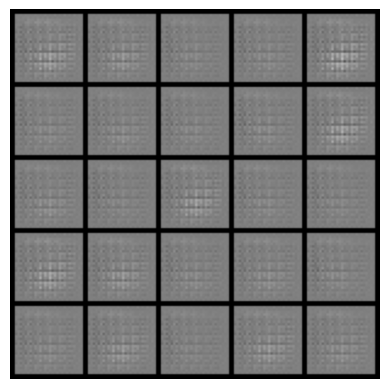

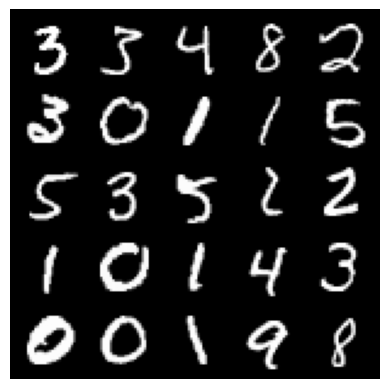

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 2.0729803278446197, discriminator loss: 0.16084535831212982


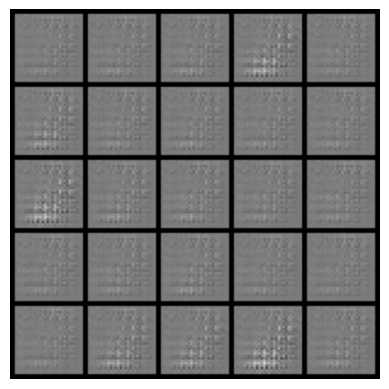

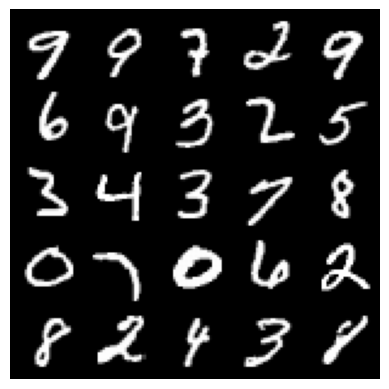

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 2.67895535713434, discriminator loss: 0.1949339104071259


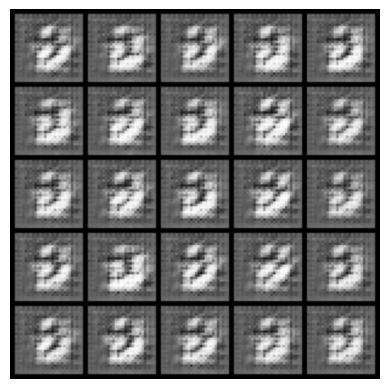

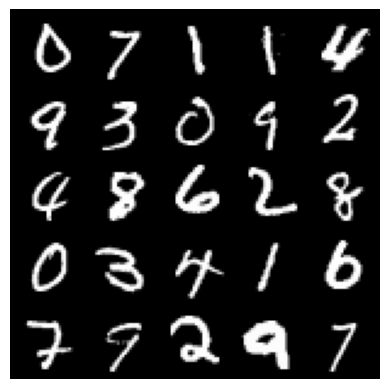

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.5679561483263964, discriminator loss: 0.4232020438015459


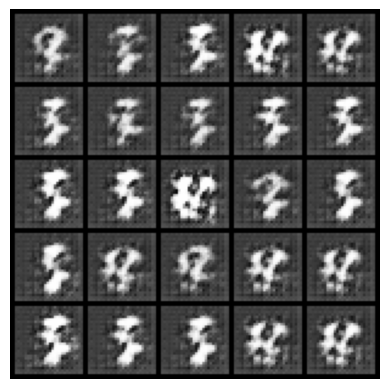

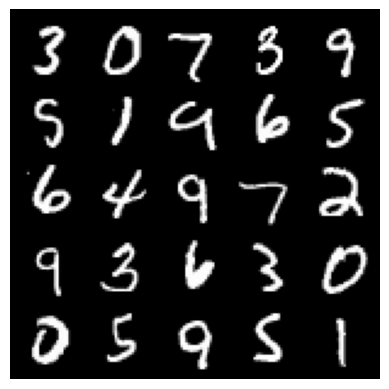

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.6696782323122048, discriminator loss: 0.37010127165913576


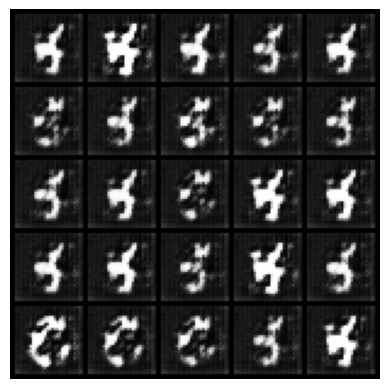

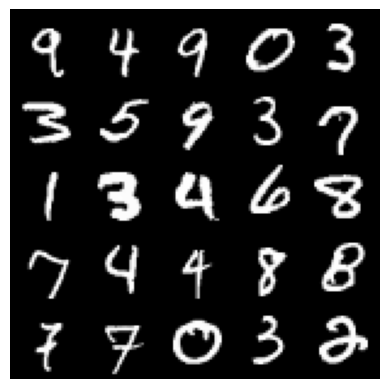

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.3785281548202049, discriminator loss: 0.45649303746223463


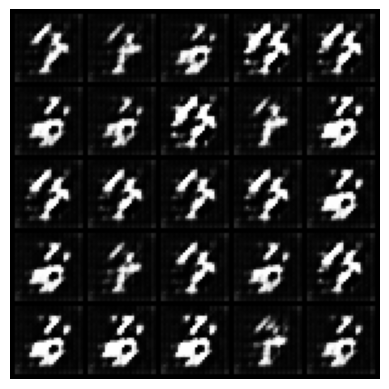

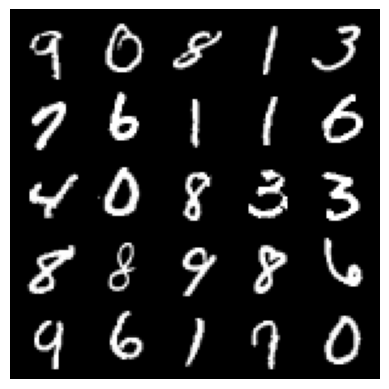

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 1.2556430602520707, discriminator loss: 0.4838173387050631


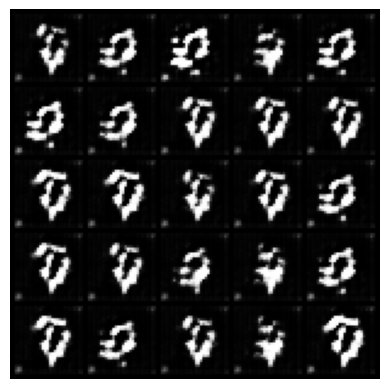

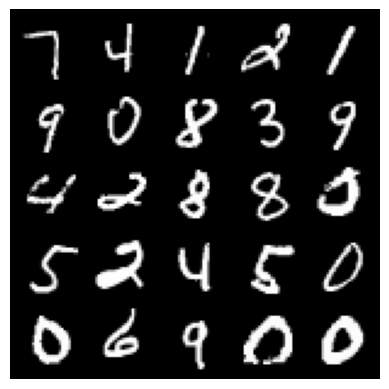

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 1.1361989080607902, discriminator loss: 0.5318938205242157


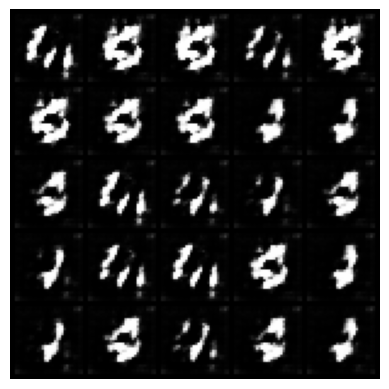

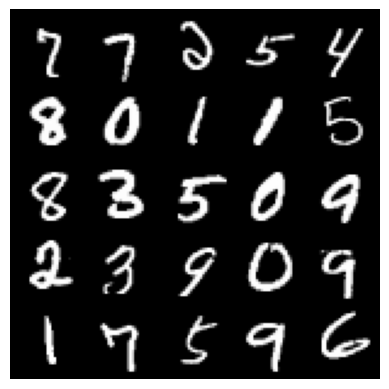

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 1.0588421338200569, discriminator loss: 0.5595325776338586


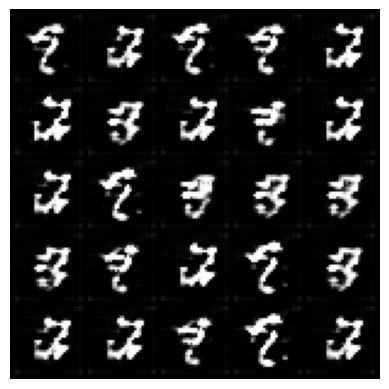

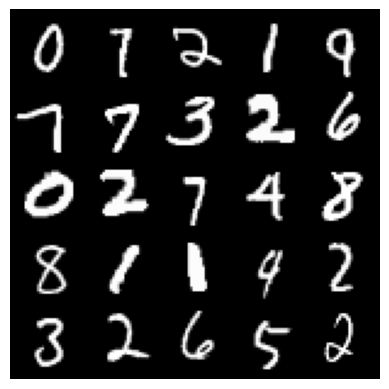

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
